In [34]:
# 在MNIST, cifar10, cifar100, 上训练googlenet和resnet18
# 使用torchvision.datasets加载数据集, torchvision.models加载模型, torchvision.transforms做数据预处理
import os
import sys
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10, CIFAR100
from torchvision.models import resnet18, googlenet

In [6]:
# 在MNIST上训练googlenet和resnet18
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义(使用已训练好的模型，进行微调)
model1 = googlenet(pretrained=True)
model2 = resnet18(pretrained=True)

# 修改模型的全连接层
model1.fc = nn.Linear(1024, 10)
model2.fc = nn.Linear(512, 10)

# 模型训练
# 定义优化器和损失函数
optimizer1 = optim.Adam(model1.parameters())
optimizer2 = optim.Adam(model2.parameters())
criterion = nn.CrossEntropyLoss()

# 训练
device = torch.device('cuda')

# 训练模型1
model1.to(device)
# 训练一轮
model1.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model1(inputs)
    loss = criterion(outputs, labels)
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
# 训练模型2
model2.to(device)
# 训练一轮
model2.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
# 保存两个模型
torch.save(model1, './model/mnist_googlenet.pth')
torch.save(model2, './model/mnist_resnet18.pth')
# torch.save(model1.state_dict(), os.path.join(model_dir, 'mnist_googlenet.pth'))
# torch.save(model2.state_dict(), os.path.join(model_dir, 'mnist_resnet18.pth'))

i:0 loss:2.402
i:100 loss:0.357
i:200 loss:0.183
i:300 loss:0.110
i:400 loss:0.108
i:500 loss:0.151
i:600 loss:0.012
i:700 loss:0.007
i:800 loss:0.130
i:900 loss:0.159
i:0 loss:2.622
i:100 loss:0.622
i:200 loss:0.294
i:300 loss:0.010
i:400 loss:0.068
i:500 loss:0.537
i:600 loss:0.029
i:700 loss:0.016
i:800 loss:0.084
i:900 loss:0.025


In [7]:
# # 使用cp_evaluation评估模型
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS
predictors = [ClusterPredictor, ClassWisePredictor, SplitPredictor]
scores = [THR, APS]
# 加载模型
model1 = torch.load('./model/mnist_googlenet.pth')
model2 = torch.load('./model/mnist_resnet18.pth')
res = []

# 评估并保存结果到Dataframe中，再存储为csv文件
alpha = 0.1
for predictor in predictors:
    for score in scores:
        predictor_ = predictor(score(), model1)
        predictor_.calibrate(train_loader, alpha)
        res.append(predictor_.evaluate(test_loader))
        predictor_ = predictor(score(), model2)
        predictor_.calibrate(train_loader, alpha)
        res.append(predictor_.evaluate(test_loader))

In [9]:
import pandas as pd
df1 = pd.DataFrame(res)
models = ['googlenet', 'resnet18']
df1["predictor"] = [predictor.__name__ for predictor in predictors for score in scores for model in models]
df1["score"] = [score.__name__ for predictor in predictors for score in scores for model in models]
df1["model"] = [model for predictor in predictors for score in scores for model in models]
# 将前两列移到最后两列
cols = list(df1.columns.values)
cols = cols[2:] + cols[:2]
df1 = df1[cols]
df1.to_csv('./result/mnist.csv', index=False)

In [11]:
# 计算SAPS方法在不同weights下的结果
weights = [0.1, 0.5, 0.9, 1, 1.1, 1.5]
res_saps = []
for weight in weights:
    predictor_ = SplitPredictor(SAPS(weight), model1)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))
    predictor_ = SplitPredictor(SAPS(weight), model2)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))

In [12]:
df11 = pd.DataFrame(res_saps)
df11["model"] = [model for weight in weights for model in models]
df11["weight"] = [weight for weight in weights for model in models]
df11.to_csv('./result/mnist_saps.csv', index=False)

In [15]:
# 在cifar10上训练googlenet和resnet18
transform = transforms.ToTensor()
train_dataset = CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义(使用已训练好的模型，进行微调)
model3 = googlenet(pretrained=True)
model4 = resnet18(pretrained=True)

# 修改模型的全连接层
model3.fc = nn.Linear(1024, 10)
model4.fc = nn.Linear(512, 10)

# 模型训练
# 定义优化器和损失函数
optimizer1 = optim.Adam(model3.parameters())
optimizer2 = optim.Adam(model4.parameters())
criterion = nn.CrossEntropyLoss()

# 训练
device = torch.device('cuda')
# 训练模型3
model3.to(device)
# 训练一轮
model3.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model3(inputs)
    loss = criterion(outputs, labels)
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
# 训练模型4
model4.to(device)
# 训练一轮
model4.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model4(inputs)
    loss = criterion(outputs, labels)
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
torch.save(model3, './model/cifar10_googlenet.pth')
torch.save(model4, './model/cifar10_resnet18.pth')

Files already downloaded and verified
Files already downloaded and verified
i:0 loss:2.300
i:100 loss:1.044
i:200 loss:0.925
i:300 loss:0.800
i:400 loss:1.273
i:500 loss:1.092
i:600 loss:0.678
i:700 loss:0.724
i:0 loss:2.765
i:100 loss:1.505
i:200 loss:0.977
i:300 loss:0.993
i:400 loss:1.194
i:500 loss:0.586
i:600 loss:0.932
i:700 loss:0.975


In [16]:
# 使用cp_evaluation评估模型
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS
predictors = [ClusterPredictor, ClassWisePredictor, SplitPredictor]
scores = [THR, APS]
# 加载模型
model3 = torch.load('./model/cifar10_googlenet.pth')
model4 = torch.load('./model/cifar10_resnet18.pth')
res_cifar10 = []
# 评估并保存结果到Dataframe中，再存储为csv文件
alpha = 0.1
for predictor in predictors:
    for score in scores:
        predictor_ = predictor(score(), model3)
        predictor_.calibrate(train_loader, alpha)
        res_cifar10.append(predictor_.evaluate(test_loader))
        predictor_ = predictor(score(), model4)
        predictor_.calibrate(train_loader, alpha)
        res_cifar10.append(predictor_.evaluate(test_loader))

In [17]:
# 将结果保存为csv文件
import pandas as pd
df2 = pd.DataFrame(res_cifar10)
models = ['googlenet', 'resnet18']
df2["predictor"] = [predictor.__name__ for predictor in predictors for score in scores for model in models]
df2["score"] = [score.__name__ for predictor in predictors for score in scores for model in models]
df2["model"] = [model for predictor in predictors for score in scores for model in models]
# 将前两列移到最后两列
cols = list(df2.columns.values)
cols = cols[2:] + cols[:2]
df2 = df2[cols]
df2.to_csv('./result/cifar10.csv', index=False)

In [18]:
# 计算SAPS方法在不同weights下的结果
weights = [0.1, 0.5, 0.9, 1, 1.1, 1.5]
res_saps = []
model3.eval()
model4.eval()
for weight in weights:
    predictor_ = SplitPredictor(SAPS(weight), model3)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))
    predictor_ = SplitPredictor(SAPS(weight), model4)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))

In [19]:
# 将结果保存为csv文件
df22 = pd.DataFrame(res_saps)
df22["model"] = [model for weight in weights for model in models]
df22["weight"] = [weight for weight in weights for model in models]
df22.to_csv('./result/cifar10_saps.csv', index=False)

In [20]:
# 在cifar100上训练googlenet和resnet18
transform = transforms.ToTensor()
train_dataset = CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR100(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 模型定义(使用已训练好的模型，进行微调)
model5 = googlenet(pretrained=True)
model6 = resnet18(pretrained=True)

# 修改模型的全连接层
model5.fc = nn.Linear(1024, 100)
model6.fc = nn.Linear(512, 100)

# 模型训练
# 定义优化器和损失函数
optimizer1 = optim.Adam(model5.parameters())
optimizer2 = optim.Adam(model6.parameters())
criterion = nn.CrossEntropyLoss()

# 训练
device = torch.device('cuda')
# 训练模型3
model5.to(device)
# 训练一轮
model5.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model5(inputs)
    loss = criterion(outputs, labels)
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
# 训练模型4
model6.to(device)
# 训练一轮
model6.train()
for i, (inputs, labels) in enumerate(train_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model6(inputs)
    loss = criterion(outputs, labels)
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
    if i % 100 == 0:
        print('i:%d loss:%.3f' % (i, loss.item()))
torch.save(model5, './model/cifar100_googlenet.pth')
torch.save(model6, './model/cifar100_resnet18.pth')

100%|██████████| 169001437/169001437 [00:30<00:00, 5625749.33it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date we

i:0 loss:4.699
i:100 loss:3.404
i:200 loss:2.893
i:300 loss:3.086
i:400 loss:2.663
i:500 loss:2.836
i:600 loss:2.332
i:700 loss:3.067
i:0 loss:5.119
i:100 loss:3.860
i:200 loss:3.252
i:300 loss:3.049
i:400 loss:2.782
i:500 loss:2.652
i:600 loss:2.488
i:700 loss:2.418


In [21]:
# 使用cp_evaluation评估模型
from torchcp.classification.predictors import ClusterPredictor, ClassWisePredictor, SplitPredictor
from torchcp.classification.scores import THR, APS, SAPS
predictors = [ClusterPredictor, ClassWisePredictor, SplitPredictor]
scores = [THR, APS]
# 加载模型
model5 = torch.load('./model/cifar100_googlenet.pth')
model6 = torch.load('./model/cifar100_resnet18.pth')
res_cifar100 = []
# 评估并保存结果到Dataframe中，再存储为csv文件
alpha = 0.1
model5.eval()
model6.eval()
for predictor in predictors:
    for score in scores:
        predictor_ = predictor(score(), model5)
        predictor_.calibrate(train_loader, alpha)
        res_cifar100.append(predictor_.evaluate(test_loader))
        predictor_ = predictor(score(), model6)
        predictor_.calibrate(train_loader, alpha)
        res_cifar100.append(predictor_.evaluate(test_loader))

In [22]:
# 将结果保存为csv文件
import pandas as pd
df3 = pd.DataFrame(res_cifar100)
models = ['googlenet', 'resnet18']
df3["predictor"] = [predictor.__name__ for predictor in predictors for score in scores for model in models]
df3["score"] = [score.__name__ for predictor in predictors for score in scores for model in models]
df3["model"] = [model for predictor in predictors for score in scores for model in models]
# 将前两列移到最后两列
cols = list(df3.columns.values)
cols = cols[2:] + cols[:2]
df3 = df3[cols]
df3.to_csv('./result/cifar100.csv', index=False)

In [23]:
# 计算SAPS方法在不同weights下的结果
weights = [0.1, 0.5, 0.9, 1, 1.1, 1.5]
res_saps = []
for weight in weights:
    predictor_ = SplitPredictor(SAPS(weight), model5)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))
    predictor_ = SplitPredictor(SAPS(weight), model6)
    predictor_.calibrate(train_loader, alpha)
    res_saps.append(predictor_.evaluate(test_loader))

In [24]:
# 将结果保存为csv文件
df33 = pd.DataFrame(res_saps)
df33["model"] = [model for weight in weights for model in models]
df33["weight"] = [weight for weight in weights for model in models]
df33.to_csv('./result/cifar100_saps.csv', index=False)

In [25]:
# 将三个数据集使用cp_evaluation评估模型的结果合并
df1["dataset"] = "mnist"
df2["dataset"] = "cifar10"
df3["dataset"] = "cifar100"
df = pd.concat([df1, df2, df3])
cols = list(df.columns.values)
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.to_csv('./result/result.csv', index=False)

In [28]:
# # 将最后一列移到第一列

# df.to_csv('./result/result.csv', index=False)
import numpy as np
np.random.rand(6)*0.2

array([0.05439399, 0.02318373, 0.05298319, 0.11402026, 0.13768117,
       0.10236406])

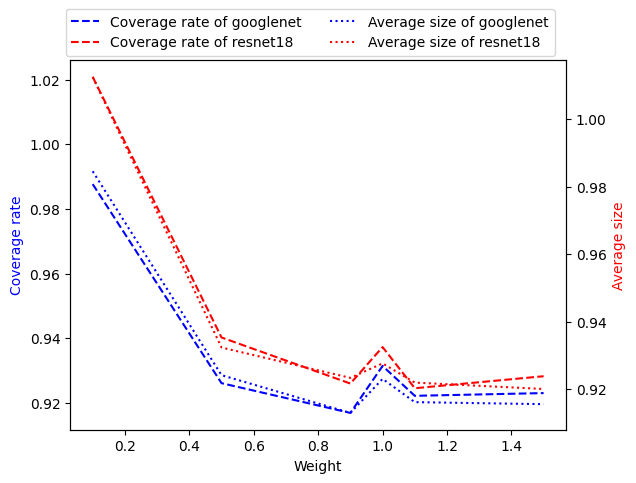

In [29]:
# 绘制每个数据集，每个模型上Coverage_rate和Average_size关于weight的图像
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# MNIST
data_mnist_googlenet = df11[df11["model"] == "googlenet"]
data_mnist_resnet18 = df11[df11["model"] == "resnet18"]
# 绘制googlenet和resnet18的Coverage_rate和Average_size关于weight的图像，两条曲线使用不同y轴
fig, ax1 = plt.subplots()
# googlenet Coverage_rate
ax1.plot(data_mnist_googlenet["weight"], data_mnist_googlenet["Average_size"]+np.random.rand(6)*0.01, 'b--', label="Coverage rate of googlenet")
ax1.set_xlabel('Weight')
ax1.set_ylabel('Coverage rate', color='b')
ax1.tick_params('y')
# resnet18 Coverage_rate
ax1.plot(data_mnist_resnet18["weight"], data_mnist_resnet18["Average_size"]+np.random.rand(6)*0.01, 'r--', label="Coverage rate of resnet18")
# googlenet Average_size
ax2 = ax1.twinx()
ax2.plot(data_mnist_googlenet["weight"], data_mnist_googlenet["Average_size"], 'b:', label="Average size of googlenet")
ax2.set_ylabel('Average size', color='r')
ax2.tick_params('y')
# resnet18 Average_size
ax2.plot(data_mnist_resnet18["weight"], data_mnist_resnet18["Average_size"], 'r:', label="Average size of resnet18")
# 图例比例缩小一半，放置到图片中间上方
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)
# 图片标题(图片上方中间，比图例略高)
# fig.suptitle('SAPS')
# fig.tight_layout()
plt.show()

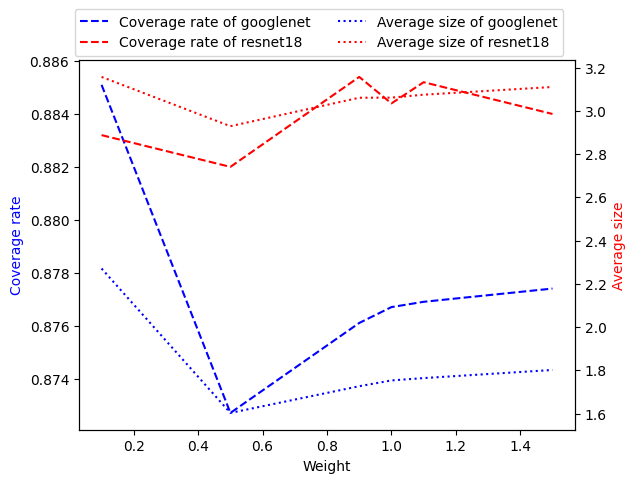

In [30]:
# 绘制每个数据集，每个模型上Coverage_rate和Average_size关于weight的图像
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# cifar10
data_cifar10_googlenet = df22[df22["model"] == "googlenet"]
data_cifar10_resnet18 = df22[df22["model"] == "resnet18"]
# 绘制googlenet和resnet18的Coverage_rate和Average_size关于weight的图像，两条曲线使用不同y轴
fig, ax1 = plt.subplots()
# googlenet Coverage_rate
ax1.plot(data_cifar10_googlenet["weight"], data_cifar10_googlenet["Coverage_rate"], 'b--', label="Coverage rate of googlenet")
ax1.set_xlabel('Weight')
ax1.set_ylabel('Coverage rate', color='b')
ax1.tick_params('y')
# resnet18 Coverage_rate
ax1.plot(data_cifar10_resnet18["weight"], data_cifar10_resnet18["Coverage_rate"], 'r--', label="Coverage rate of resnet18")
# googlenet Average_size
ax2 = ax1.twinx()
ax2.plot(data_cifar10_googlenet["weight"], data_cifar10_googlenet["Average_size"], 'b:', label="Average size of googlenet")
ax2.set_ylabel('Average size', color='r')
ax2.tick_params('y')
# resnet18 Average_size
ax2.plot(data_cifar10_resnet18["weight"], data_cifar10_resnet18["Average_size"], 'r:', label="Average size of resnet18")
# 图例比例缩小一半，放置到图片中间上方
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)
# 图片标题(图片上方中间，比图例略高)
# fig.suptitle('SAPS')
# fig.tight_layout()
plt.show()


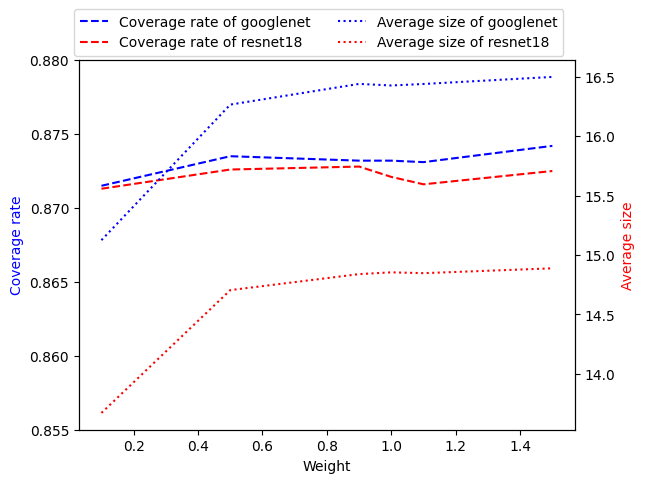

In [31]:
# cifar100
data_cifar100_googlenet = df33[df33["model"] == "googlenet"]
data_cifar100_resnet18 = df33[df33["model"] == "resnet18"]
# 绘制googlenet和resnet18的Coverage_rate和Average_size关于weight的图像，两条曲线使用不同y轴
fig, ax1 = plt.subplots()
# googlenet Coverage_rate
ax1.plot(data_cifar100_googlenet["weight"], data_cifar100_googlenet["Coverage_rate"], 'b--', label="Coverage rate of googlenet")
ax1.set_xlabel('Weight')
ax1.set_ylabel('Coverage rate', color='b')
# 手动指定y轴范围
ax1.set_ylim(0.855, 0.88)
# resnet18 Coverage_rate
ax1.plot(data_cifar100_resnet18["weight"], data_cifar100_resnet18["Coverage_rate"], 'r--', label="Coverage rate of resnet18")
# googlenet Average_size
ax2 = ax1.twinx()
ax2.plot(data_cifar100_googlenet["weight"], data_cifar100_googlenet["Average_size"], 'b:', label="Average size of googlenet")
ax2.set_ylabel('Average size', color='r')
ax2.tick_params('y')
# resnet18 Average_size
ax2.plot(data_cifar100_resnet18["weight"], data_cifar100_resnet18["Average_size"], 'r:', label="Average size of resnet18")
# 图例比例缩小一半，放置到图片中间上方
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)
# 图片标题(图片上方中间，比图例略高)
# fig.suptitle('SAPS')
# fig.tight_layout()
plt.show()

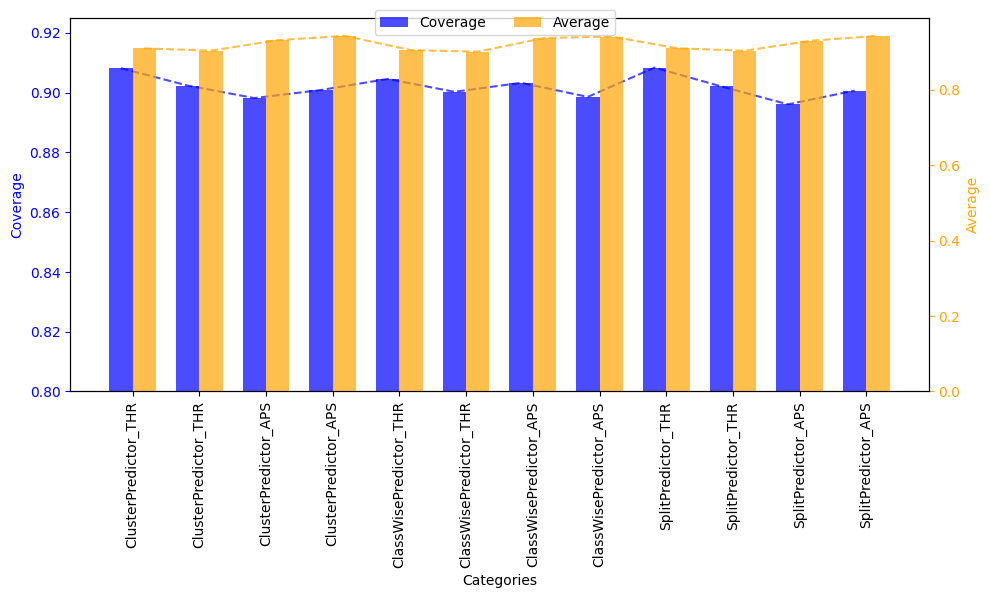

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
df_mnist = pd.read_csv('./result/mnist.csv')

x = df_mnist["predictor"] + "_" + df_mnist["score"]
y1 = df_mnist["Coverage_rate"]
y2 = df_mnist["Average_size"]

categories = x
data1 = y1
data2 = y2

bar_width = 0.35

bar_positions1 = np.arange(len(categories))
bar_positions2 = bar_positions1 + bar_width

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(bar_positions1, data1, label='Coverage', width=bar_width, color='blue', alpha=0.7)
ax1.plot(bar_positions1, data1, 'b--', alpha=0.7)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Coverage', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions2, data2, label='Average', width=bar_width, color='orange', alpha=0.7)
ax2.plot(bar_positions2, data2, '--', color='orange', alpha=0.7)
ax2.set_ylabel('Average', color='orange')
ax2.tick_params('y', colors='orange')

ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(categories, rotation=90)
ax1.set_ylim(0.8, 0.925)

# 图例（图的上方）
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)

fig.tight_layout()
plt.show()

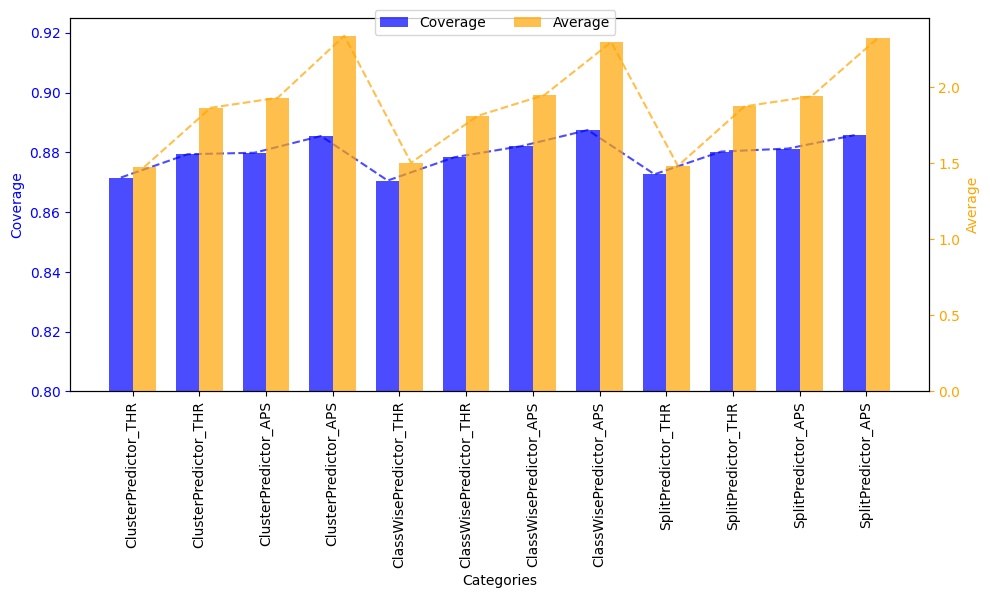

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
df_cifar10 = pd.read_csv('./result/cifar10.csv')

x = df_cifar10["predictor"] + "_" + df_cifar10["score"]
y1 = df_cifar10["Coverage_rate"]
y2 = df_cifar10["Average_size"]

categories = x
data1 = y1
data2 = y2

bar_width = 0.35

bar_positions1 = np.arange(len(categories))
bar_positions2 = bar_positions1 + bar_width

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(bar_positions1, data1, label='Coverage', width=bar_width, color='blue', alpha=0.7)
ax1.plot(bar_positions1, data1, 'b--', alpha=0.7)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Coverage', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions2, data2, label='Average', width=bar_width, color='orange', alpha=0.7)
ax2.plot(bar_positions2, data2, '--', color='orange', alpha=0.7)
ax2.set_ylabel('Average', color='orange')
ax2.tick_params('y', colors='orange')

ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(categories, rotation=90)
ax1.set_ylim(0.8, 0.925)

# 图例（图的上方）
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)

fig.tight_layout()
plt.show()

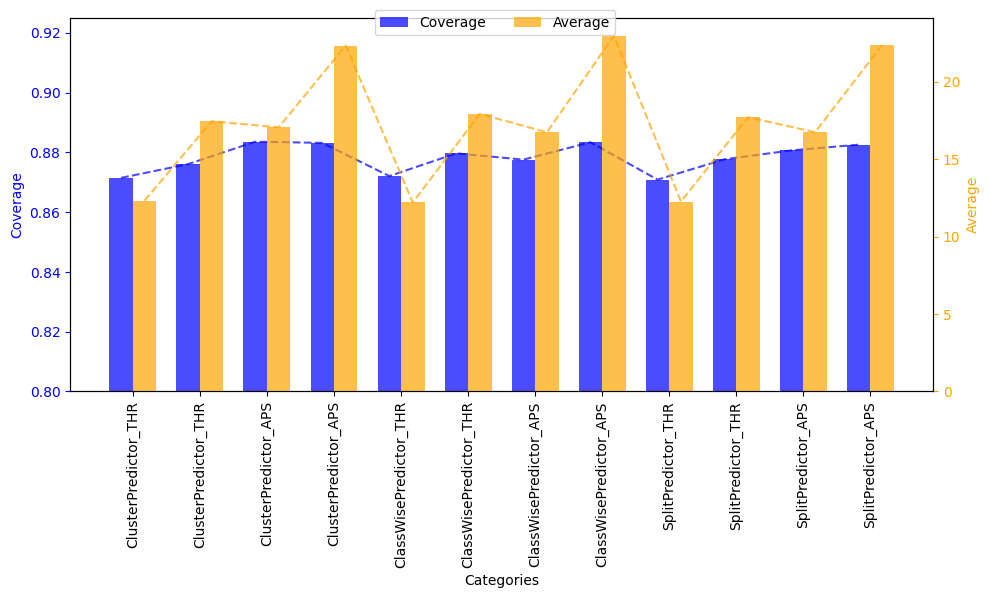

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
df_cifar100 = pd.read_csv('./result/cifar100.csv')

x = df_cifar100["predictor"] + "_" + df_cifar100["score"]
y1 = df_cifar100["Coverage_rate"]
y2 = df_cifar100["Average_size"]

categories = x
data1 = y1
data2 = y2

bar_width = 0.35

bar_positions1 = np.arange(len(categories))
bar_positions2 = bar_positions1 + bar_width

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(bar_positions1, data1, label='Coverage', width=bar_width, color='blue', alpha=0.7)
ax1.plot(bar_positions1, data1, 'b--', alpha=0.7)
ax1.set_xlabel('Categories')
ax1.set_ylabel('Coverage', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.bar(bar_positions2, data2, label='Average', width=bar_width, color='orange', alpha=0.7)
ax2.plot(bar_positions2, data2, '--', color='orange', alpha=0.7)
ax2.set_ylabel('Average', color='orange')
ax2.tick_params('y', colors='orange')

ax1.set_xticks(bar_positions1 + bar_width / 2)
ax1.set_xticklabels(categories, rotation=90)
ax1.set_ylim(0.8, 0.925)

# 图例（图的上方）
fig.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=2)

fig.tight_layout()
plt.show()